# Parameter configurations

In [1]:
num_input_frames = 4
num_forecast_frames = 20

# Load finetuned model

In [2]:
import os
import json
from dgmr import DGMR
import torch

model_ckpt_path = "checkpoint/dgmr_forecast18_train50k_ep10/global_step=6000.0.ckpt"

global_step = model_ckpt_path.split('.')[0].split('=')[1]

model = DGMR(forecast_steps=num_forecast_frames)
checkpoint = torch.load(model_ckpt_path)
model.load_state_dict(checkpoint['state_dict'])
model.cuda()
model.eval()

model.config['forecast_steps'] = num_forecast_frames
model.sampler.forecast_steps = num_forecast_frames

/home/ec2-user/SageMaker/efs/conda_envs/dgmr_py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions used to visualize results

In [3]:
import datetime
import os

import cartopy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import shapely.geometry as sgeom
import tensorflow as tf
# import tensorflow_hub

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from mpl_toolkits.axes_grid1 import make_axes_locatable

matplotlib.rc('animation', html='jshtml')

def horizontally_concatenate_batch(samples):
    n, t, c, h, w = samples.shape
    # N, T, C, H, W, C => T, H, N, W, C
    samples = samples.permute(1, 3, 0, 4, 2)
    # T, H, N, W, C => T, H, N*W, C
    samples = samples.reshape(t, h, n*w, c)
    return samples

def vertically_concatenate_batch(samples):
    n, t, c, h, w = samples.shape
    # N, T, C, H, W, C => T, N, H, W, C
    samples = samples.permute(1, 0, 3, 4, 2)
    # T, N, H, W, C => T, N*H, W, C
    samples = samples.reshape(t, n*h, w, c)
    return samples

def plot_single_frame(image, figsize=(8, 6), vmin=0, vmax=75):

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the data as an image
    im = ax.imshow(image, vmin=vmin, vmax=vmax, cmap='jet')  # viridis 

    # Add a colorbar beside the figure
    cbar = fig.colorbar(im, ax=ax, shrink=1)

    # Add a label to the colorbar
    cbar.set_label('radar signal strength', rotation=270, labelpad=20)
    plt.show()

# def plot_animation(field, figsize=None, vmin=0, vmax=10, cmap="jet", **imshow_args):
#     # field, T W H C
#     fig = plt.figure(figsize=figsize)
#     ax = plt.axes()
#     ax.set_axis_off()
#     plt.close() # Prevents extra axes being plotted below animation
#     img = ax.imshow(field[0, ..., 0], vmin=vmin, vmax=vmax, cmap=cmap, **imshow_args)

#     def animate(i):
#         img.set_data(field[i, ..., 0])
#         return (img,)

#     return animation.FuncAnimation(
#       fig, animate, frames=field.shape[0], interval=24, blit=False)

def plot_animation(field, figsize=None, vmin=0, vmax=10, cmap="jet", **imshow_args):
    # field, T W H C
    fig = plt.figure(figsize=figsize)
    ax = plt.axes()
    ax.set_axis_off()
    plt.close()  # Prevents extra axes being plotted below animation
    img = ax.imshow(field[0, ..., 0], vmin=vmin, vmax=vmax, cmap=cmap, **imshow_args)

    def animate(i):
        img.set_data(field[i, ..., 0])
        return (img,)

    fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    return animation.FuncAnimation(
        fig, animate, frames=field.shape[0], interval=24, blit=False)

class ExtendedOSGB(cartopy.crs.OSGB):
    """MET office radar data uses OSGB36 with an extended bounding box."""

    def __init__(self):
        super().__init__(approx=False)

    @property
    def x_limits(self):
        return (-405000, 1320000)

    @property
    def y_limits(self):
        return (-625000, 1550000)
    
    @property
    def boundary(self):
        x0, x1 = self.x_limits
        y0, y1 = self.y_limits
        return sgeom.LinearRing([(x0, y0), (x0, y1), (x1, y1), (x1, y0), (x0, y0)])


def plot_rows_on_map(rows, field_name="radar_frames", timestep=0, num_rows=None,
                     cbar_label=None, **imshow_kwargs):
    fig = plt.figure(figsize=(10, 10))
    axes = fig.add_subplot(1, 1, 1, projection=ExtendedOSGB())
    if num_rows is None:
        num_rows = next(iter(rows.values())).shape[0]
    for b in range(num_rows):
        extent = (rows["osgb_extent_left"][b].numpy(),
                  rows["osgb_extent_right"][b].numpy(),
                  rows["osgb_extent_bottom"][b].numpy(),
                  rows["osgb_extent_top"][b].numpy())
        im = axes.imshow(rows[field_name][b, timestep, ..., 0].numpy(),
                    extent=extent, **imshow_kwargs)

    axes.set_xlim(*axes.projection.x_limits)
    axes.set_ylim(*axes.projection.y_limits)
    axes.set_facecolor("black")
    axes.gridlines(alpha=0.5)
    axes.coastlines(resolution="50m", color="white")
    if cbar_label:
        cbar = fig.colorbar(im)
        cbar.set_label(cbar_label)
    return fig


def plot_animation_on_map(frames, extent, vmin=0, vmax=75, figsize=(10, 6)):
    fig = plt.figure(figsize=figsize)
    axes = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    plt.close()  # Prevents extra axes being plotted below animation

    # Add gridlines, coastlines, borders, and land/water features for better contrast
    axes.gridlines(alpha=0.5)
    axes.coastlines(resolution="50m", color="white")
    axes.add_feature(cfeature.BORDERS, linestyle=':')
    
    # axes.add_feature(cfeature.LAND, edgecolor='white')
    
    land = NaturalEarthFeature('physical', 'land', '50m', edgecolor='white', facecolor='none')
    axes.add_feature(land, zorder=1)  # Ensure it is on top with proper zorder

    axes.add_feature(cfeature.OCEAN)
    axes.set_extent(extent, crs=ccrs.PlateCarree())

    # Assuming frames is a numpy array or similar with shape (time, height, width, channels)
    img = axes.imshow(
        frames[0, ..., 0],  # Use the first time frame's first channel
        extent=extent, vmin=vmin, vmax=vmax, cmap="jet", transform=ccrs.PlateCarree(), origin='upper')

    # Create an axis on the right for the color bar
    divider = make_axes_locatable(axes)
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
    cbar = fig.colorbar(img, cax=cax)
    cbar.set_label("Radar signal strength, dbz")

    def animate(i):
        img.set_data(frames[i, ..., 0])
        return img,

    return animation.FuncAnimation(
        fig, animate, frames=frames.shape[0],
        interval=24, blit=True)


def plot_mask_on_map(row):
    fig = plt.figure(figsize=(10, 10))
    axes = fig.add_subplot(1, 1, 1, projection=ExtendedOSGB())
    axes.gridlines(alpha=0.5)
    axes.coastlines(resolution="50m", color="black")

    extent = (row["osgb_extent_left"].numpy(),
            row["osgb_extent_right"].numpy(),
            row["osgb_extent_bottom"].numpy(),
            row["osgb_extent_top"].numpy())

    img = axes.imshow(
      row["radar_mask"][0, ..., 0].numpy(),
      extent=extent, vmin=0, vmax=1, cmap="viridis")

2024-05-21 07:25:38.429188: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 07:25:41.134855: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Inference on cropped radar images (256 x 256)

In [4]:
import random
import torch
import os
import numpy as np

def revert_back_numpy_array(byte_array, size=(24, 256, 256), dtype=np.float32, source_dtype=np.float32):
    # Load the flattened data from disk
    flattened_data = bytearray(byte_array) 

    # Convert the bytearray to a numpy array
    flattened_array = np.frombuffer(flattened_data, dtype=source_dtype)
    # Reshape the flattened array to the original shape
    original_shape = size
    original_array = flattened_array.reshape(original_shape).astype(dtype)
    
    return original_array


class MyCollator(object):
    def __init__(self, num_input_frames, num_forecast_frames):
        self.num_input_frames = num_input_frames
        self.num_forecast_frames = num_forecast_frames
        
    def __call__(self, examples):
        # do something with batch and self.params
        inputs, targets = [], []
        for i, example in enumerate(examples):
            cropped_frames = revert_back_numpy_array(example["cropped_frames"], size=(24, 256, 256), dtype=np.float32)
            position = revert_back_numpy_array(example["position"], size=(3), dtype=np.uint8, source_dtype=np.float32)
           
            input_frames = cropped_frames[:self.num_input_frames, ...]
            target_frames = cropped_frames[self.num_input_frames:self.num_input_frames+self.num_forecast_frames, ...]

            inputs.append(input_frames)
            targets.append(target_frames)

        inputs_tensor = torch.Tensor(np.stack(inputs)).unsqueeze(2)
        targets_tensor = torch.Tensor(np.stack(targets)).unsqueeze(2)

        return inputs_tensor, targets_tensor

In [5]:
import os
from datasets import load_dataset

test_data_dir = "./data/zuimei-radar-cropped/test"  # test data starts from 20240301

test_dataset = load_dataset("webdataset", 
                    data_files={"test": os.path.join(test_data_dir,"*.tar")}, 
                    split="test", 
                    streaming=True)

In [6]:
batch_size = 1

test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        shuffle=False,
        collate_fn=MyCollator(num_input_frames, num_forecast_frames),
        batch_size=batch_size,
        num_workers=1,
    )

In [7]:
from collections import defaultdict
import tarfile

def count_distinct_files(folder_path):
    # distinct_files = defaultdict(set)
    # for filename in os.listdir(folder_path):
    #     if filename.endswith('.tar'):
    #         tar_path = os.path.join(folder_path, filename)
    #         with tarfile.open(tar_path, 'r') as tar:
    #             for member in tar.getmembers():
    #                 if member.isfile():
    #                     file_name = os.path.basename(member.name)
    #                     file_prefix, _ = os.path.splitext(file_name)
    #                     distinct_files[file_prefix].add(file_name)
    # return len(distinct_files)

    filenames = [filename for filename in os.listdir(folder_path) if filename.endswith('.tar')]
    
    return len(filenames) * 20  # 20 examples per tar file

In [8]:
test_data_len = count_distinct_files(test_data_dir)
test_loader_len = test_data_len // batch_size
print(f"Number of test examples: {test_data_len}")
print(f"Number of batches: {test_loader_len}")

Number of test examples: 400
Number of batches: 400


In [9]:
from tqdm import tqdm

target_frames_list = []
pred_frames_list = []

num_test = min(10, test_data_len)

for step, batch in tqdm(enumerate(test_dataloader), total=num_test):
    
    if step >= num_test:
        break
        
    input_frames = batch[0]
    target_frames = batch[1]
    
    with torch.no_grad():
        pred_frames = model(input_frames.cuda())
        pred_frames[pred_frames<0] = 0
    
    target_frames_list.append(target_frames)
    pred_frames_list.append(pred_frames.cpu())

100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


## Visualize some forecast results

In [10]:
target_pred_frames = torch.cat((target_frames_list[0], pred_frames_list[0]), dim=0)
target_pred_frames.shape

torch.Size([2, 20, 1, 256, 256])

In [11]:
anim = plot_animation(horizontally_concatenate_batch(target_pred_frames).numpy(), figsize=(10, 5), vmax=75)
anim.save(f'outputs/animation_ckpt_{int(global_step)//1000}k.gif', writer='pillow', fps=5)
anim

## Calculate CSI

In [12]:
import torch
from torchmetrics.regression import CriticalSuccessIndex

def calculate_average_csi(pred_frames_list, target_frames_list, threshold=20):
    '''
        calculate the critical success index for pred_frames_list, target_frames_list
        
    '''
    csi = CriticalSuccessIndex(threshold, keep_sequence_dim=0)
    
    assert len(pred_frames_list) == len(target_frames_list)
    csi_results = []
    for pred_frames, target_frames in zip(pred_frames_list, target_frames_list):
        csi_result = csi(pred_frames.squeeze(), target_frames.squeeze())
        csi_results.append(csi_result)
    
    csi_results = np.asarray(csi_results)
    
    return np.mean(csi_results, axis=0)

In [13]:
import matplotlib.pyplot as plt

def plot_csi(targets, results_pretrained, results_finetuned, threshold=10, ckpt=1000):

    csi_pretrained = calculate_average_csi(targets, results_pretrained, threshold=threshold)
    csi_finetuned = calculate_average_csi(targets, results_finetuned, threshold=threshold)
    time_range = range(1, num_forecast_frames+1)
    
    np.save(f"logs/csi_pretrained_{threshold}.npy", csi_pretrained)
    np.save(f"logs/csi_finetuned_{ckpt}_{threshold}.npy", csi_finetuned)
    
    plt.figure()
    plt.plot(time_range, csi_pretrained, 'r', time_range, csi_finetuned, 'b')
    plt.xlabel('time steps')
    plt.ylabel('CSI')
    plt.legend(['pretrained', 'finetuned'])
    plt.show()

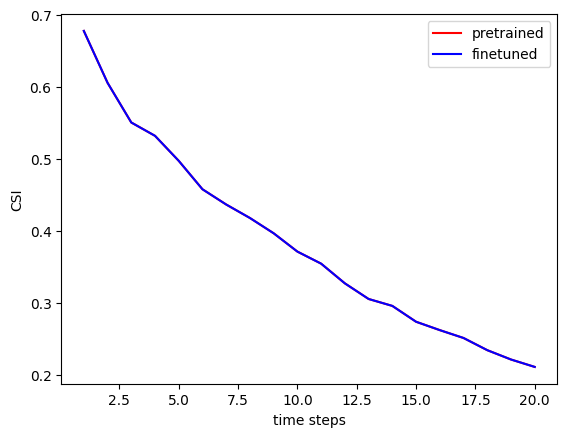

In [14]:
plot_csi(target_frames_list, pred_frames_list, pred_frames_list, threshold=5, ckpt=global_step)

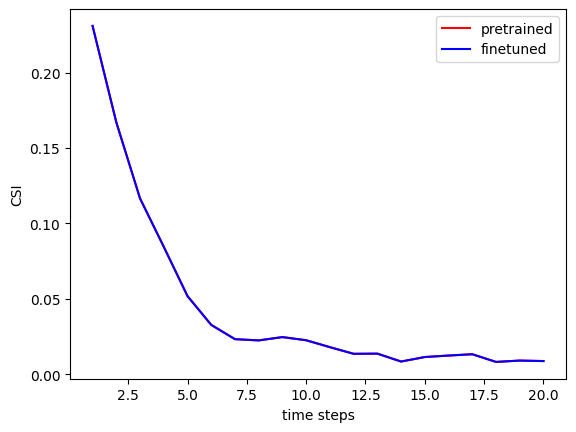

In [15]:
plot_csi(target_frames_list, pred_frames_list, pred_frames_list, threshold=20, ckpt=global_step)

# Inference on raw radar images (4200 x 6200)

In [16]:
import zipfile
import os
import re
from functools import cmp_to_key
from datetime import datetime, timedelta
from PIL import Image
import json
import random
# import pickle
import webdataset as wds
import numpy as np
from tqdm import tqdm
import pandas as pd
import time
import uuid

data_dir = "data/zuimei-radar"

def get_file_paths(directory):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.zip'):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)
                
                # try:
                #     with zipfile.ZipFile(file_path, 'r') as zip_file:
                #         # Check if the ZIP file is complete
                #         bad_file = zip_file.testzip()
                #         if bad_file is None:
                #             # The ZIP file is complete
                #             file_paths.append(file_path)
                #         else:
                #             print(f"Warning: '{file_path}' is a corrupted ZIP file.")
                # except zipfile.BadZipFile:
                #     print(f"Warning: '{file_path}' is not a valid ZIP file.")
                    
    return file_paths


def sort_key(file_path):
    match = re.search(r'BABJ_(\d+)_P', file_path)
    if match:
        return int(match.group(1))
    else:
        return float('inf')


# Example usage
file_paths = get_file_paths(data_dir)
print(f"number of files: {len(file_paths)}")
print("before sort: \n", file_paths[:5])

file_paths.sort(key=cmp_to_key(lambda x, y: (sort_key(x) > sort_key(y)) - (sort_key(x) < sort_key(y))))

print("after sort: \n", file_paths[:5])

# get consecutive time periods
def get_time_from_path(file_path, return_type='datetime'):
    match = re.search(r'BABJ_(\d+)_P', file_path)
    if match:
        time_str = match.group(1)
        if return_type == 'datetime':
            return datetime.strptime(time_str, '%Y%m%d%H%M%S')
        else:
            return time_str
    else:
        return None

times = [get_time_from_path(path) for path in file_paths]
times.sort()

periods = []
current_period = []

for i in range(len(times)):
    current_time = times[i]
    if i == 0 or (times[i] - times[i - 1]).total_seconds() >= 355 and (times[i] - times[i - 1]).total_seconds() <= 365:
        current_period.append(file_paths[i])
    else:
        periods.append(current_period)
        current_period = [file_paths[i]]

if current_period:
    periods.append(current_period)

print(f"Periods of consecutive file paths: {len(periods)}")
# for period in periods[:5]:
#     print(period)

def read_data(file_path):
    # Open the ZIP file
    with zipfile.ZipFile(file_path, 'r') as zip_file:
        # Get the name of the file inside the ZIP archive
        file_name = zip_file.namelist()[0]

        # Open the file inside the ZIP archive
        with zip_file.open(file_name) as file:
            # Load the NumPy array from the file
            data = np.loadtxt(file)
    
    return data

        
# Print the loaded NumPy array
data = read_data(file_paths[0])
print(type(data), data.shape)

count = sum([1 for period in periods if len(period)>=24])

lens = [len(period) for period in periods if len(period)>=0]
print(count)
print(lens)

def read_data(file_path):
    # Open the ZIP file
    with zipfile.ZipFile(file_path, 'r') as zip_file:
        # Get the name of the file inside the ZIP archive
        file_name = zip_file.namelist()[0]

        # Open the file inside the ZIP archive
        with zip_file.open(file_name) as file:
            # Load the NumPy array from the file
            data = np.loadtxt(file)
    
    return data


def read_frames(file_paths, vmin=0, vmax=75):
    
    frames = []
    for file_path in file_paths:
        try:
            data = read_data(file_path)
            frames.append(data)
        except Exception as e:
            print(f"{e}: {file_path}")
    
    frames = np.stack(frames, axis=0)
    frames[np.isnan(frames)] = 0
    frames[frames>vmax] = vmax
    frames[frames<vmin] = vmin
    frames = frames.astype(np.float32)
    
    return frames

number of files: 1082
before sort: 
 ['data/zuimei-radar/20240305/Z_RADA_C_BABJ_20240305112414_P_ACHN.QREF.20240305.111800.bin.zip', 'data/zuimei-radar/20240305/Z_RADA_C_BABJ_20240305043016_P_ACHN.QREF.20240305.042400.bin.zip', 'data/zuimei-radar/20240305/Z_RADA_C_BABJ_20240304192416_P_ACHN.QREF.20240304.191800.bin.zip', 'data/zuimei-radar/20240305/Z_RADA_C_BABJ_20240305041216_P_ACHN.QREF.20240305.040600.bin.zip', 'data/zuimei-radar/20240305/Z_RADA_C_BABJ_20240305141214_P_ACHN.QREF.20240305.140600.bin.zip']
after sort: 
 ['data/zuimei-radar/20240301/Z_RADA_C_BABJ_20240229160014_P_ACHN.QREF.20240229.155400.bin.zip', 'data/zuimei-radar/20240301/Z_RADA_C_BABJ_20240229160614_P_ACHN.QREF.20240229.160000.bin.zip', 'data/zuimei-radar/20240301/Z_RADA_C_BABJ_20240229161214_P_ACHN.QREF.20240229.160600.bin.zip', 'data/zuimei-radar/20240301/Z_RADA_C_BABJ_20240229161814_P_ACHN.QREF.20240229.161200.bin.zip', 'data/zuimei-radar/20240301/Z_RADA_C_BABJ_20240229162415_P_ACHN.QREF.20240229.161800.bin.zip

In [18]:
num_total_frames = 24
period_frames_raw = read_frames(periods[5][:num_total_frames])
_, width_raw, height_raw = period_frames_raw.shape
period_frames_raw.shape

(24, 4200, 6200)

In [19]:
def pad_frames(arr, base_num=32):
    # print("Original array shape:", arr.shape)

    # Calculate the padding needed for each dimension
    pad_dim1 = (base_num - arr.shape[1] % base_num) % base_num
    pad_dim2 = (base_num - arr.shape[2] % base_num) % base_num

    # Calculate the padding amount for each side
    pad_width = ((0, 0), (0, pad_dim1), (0, pad_dim2))

    # Pad the array with zeros
    padded_arr = np.pad(arr, pad_width, mode='constant', constant_values=0)
    padded_arr = padded_arr.astype(np.float32)
    
    return padded_arr

In [20]:
period_frames_pad = pad_frames(period_frames_raw)
period_frames_pad.shape

period_frames = period_frames_pad

In [21]:
input_frames = period_frames[:num_input_frames]
target_frames = period_frames[num_input_frames:num_input_frames+num_forecast_frames]

print(input_frames.shape, target_frames.shape)

(4, 4224, 6208) (20, 4224, 6208)


In [22]:
width, height = input_frames.shape[1], input_frames.shape[2]
print(f"width: {width}, height: {height}")

width: 4224, height: 6208


In [23]:
num_subframe = 4 # for each large radar, do inference in 4 times

model.config['forecast_steps'] = num_forecast_frames
model.sampler.forecast_steps = num_forecast_frames
model.latent_stack.shape = (8, width//num_subframe//32, height//32)

In [25]:
import torch
import time

pred_frames = []

start_time = time.time()
with torch.no_grad():
    for i in range(num_subframe):        
        pred_subframes = model(torch.tensor(input_frames[:,i*width//num_subframe:(i+1)*width//num_subframe,:]).unsqueeze(0).unsqueeze(2).cuda())
        pred_subframes[pred_subframes<0] = 0
        
        pred_frames.append(pred_subframes)

time_cost = time.time() - start_time

pred_frames = torch.cat(pred_frames, dim=3)

print(pred_frames.shape)
print(f"time cost for 1 inference: {time_cost}s.")

torch.Size([1, 20, 1, 4224, 6208])
time cost for 1 inference: 14.133103132247925s.


In [26]:
target_frames = target_frames[:, :width_raw, :height_raw]
pred_frames = pred_frames[:, :, :, :width_raw, :height_raw]

print(pred_frames.shape)

torch.Size([1, 20, 1, 4200, 6200])


## plot the animation on map

In [27]:
extent = [75, 135, 12.2, 54.2]  # 精度范围，纬度范围， 0.01步长

In [28]:
plot_animation_on_map(target_frames[..., np.newaxis], extent, figsize=(8, 5))

In [29]:
plot_animation_on_map(pred_frames.squeeze().unsqueeze(-1).cpu(), extent, figsize=(8, 5))

In [30]:
target_pred_frames = torch.cat((torch.tensor(target_frames[np.newaxis, :, np.newaxis, ...]), pred_frames.cpu()), dim=0)
target_pred_frames.shape

torch.Size([2, 20, 1, 4200, 6200])

In [31]:
anim_full = plot_animation(horizontally_concatenate_batch(target_pred_frames).numpy(), figsize=(10, 3.5), vmax=75)
anim_full.save(f'outputs/animation_full_ckpt_{int(global_step)//1000}k.gif', writer='pillow', fps=5)
anim_full